In [196]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from numba import jit, njit
from scipy.stats import  t

In [197]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    # Wiener Process by default
    # use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    @staticmethod
    @njit
    def EulerDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        xs = x0 + bxt(x0, t0, params) * (t - t0)
        sigma2 = sigmaxt(x0, t0, params)**2 * (t - t0)

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def OzakiDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        K = 1 / (t - t0) * np.log(1 + bxt(x0, t0, params) / (x0 * bxt_x(x0, t0, params)) * (np.exp(bxt_x(x0, t0, params) * (t - t0)) - 1))
        E = x0 + bxt(x0, t0, params) / bxt_x(x0, t0, params) * (np.exp(bxt_x(x0, t0, params) * (t - t0)) - 1)
        V = sigmaxt(x0, t0, params)**2 / (2 * K) * (np.exp(2 * K * (t - t0)) - 1)
       
        if K == 0:
            K = K + 0.001
        if E == 0:
            E = E + 0.001
        if V == 0:
            V = V + 0.001
            
        xs = E
        sigma2 = V

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def ShojiOzakiDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        L = bxt_x(x0, t0, params)

        #safe division
        if L == 0:
            L = L + 0.001
        
        M = sigmaxt(x0, t0, params)**2 / 2 * bxt_xx(x0, t0, params) + bxt_t(x0, t0, params)

        A = 1 + bxt(x0, t0, params) / (x0 * L) * (np.exp(L * (t - t0)) - 1) + M / (x0 * L**2) * \
            (np.exp(L * (t - t0)) - 1 - L * (t - t0))
        B = sigmaxt(x0, t0, params)**2 * 1/(2 * L) * (np.exp(2 * L * (t - t0)) - 1)

        xs = A * x0
        sigma2 = B

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def KesslerDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        E = x0 + bxt(x0, t0, params) * (t - t0) + (bxt(x0, t0, params) * bxt_x(x0, t0, params) + 1/2 * \
            sigmaxt(x0, t0, params)**2 * bxt_xx(x0, t0, params)) * 1/2 * (t - t0)**2
        V = x0**2 + (2 * bxt(x0, t0, params) * x0 + sigmaxt(x0, t0, params)**2 ) * (t - t0)\
            + (2 * bxt(x0, t0, params) * (bxt_x(x0, t0, params) * x0 + bxt(x0, t0, params) + \
                sigmaxt(x0, t0, params) * sigmaxt_x(x0, t0, params))\
            + sigmaxt(x0, t0, params)**2 * (bxt_xx(x0, t0, params) * x0 + 2 * bxt_x(x0, t0, params) +\
                sigmaxt_x(x0, t0, params)**2 + sigmaxt(x0, t0, params) * sigmaxt_xx(x0, t0, params))) * (t - t0)**2 / 2 - E**2

        xs = E

        #safe division
        if V == 0:
            V = V + 0.001

        sigma2 = V

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def MLogLik(params, t_data, x_data, density, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        Nt = len(x_data)
        Nx = len(x_data[0])
        log_data = np.zeros(Nx)
        for k in range(0, Nx):
            m_log_lik = 0
            for j in range(1, Nt):
                m_log_lik += density(x_data[j][k], t_data[j], x_data[j - 1][k], t_data[j - 1], params,
                                     bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t)
            log_data[k] = m_log_lik

        res = -np.mean(log_data)
        return res

    def EulerEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.EulerDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def OzakiEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.OzakiDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def ShojiOzakiEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.ShojiOzakiDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def KesslerEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.KesslerDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta, mu, sigma]

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * (params[1] - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

class CKLSprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * x**params[3]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * params[3] * x**(params[3] - 1)

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return params[2] * params[3] * (params[3] - 1) * x**(params[3] - 2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

class Task5process(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * t * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[1] * x

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[0] * t

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return params[0] * x

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

class HullWhiteprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * t * (params[1] * np.sqrt(t) - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * t

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[0] * t

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return params[0] * params[1] * 3/2 * np.sqrt(t)

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

Task 1. Evaluate the conditional density of the Ornstein-Uhlenbeck process
$$dX_t = (3-X_t)dt+2dW_t, \quad X_0=1, \quad %\theta=(1, 3, 2), \quad
N=100000,
\quad \Delta=1$$ and calculate the
maximum likelihood estimation.  

In [198]:
Nx = 1000
Nt = 300

T = 1

params_OU = np.array([3, 1, 2])

x0 = 1
init_state = x0 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.EulerSolution()

In [199]:
OUp.EulerEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -222.05428934143168
        x: [ 2.929e+00  9.954e-01  1.999e+00]
      nit: 15
      jac: [ 1.990e-05  3.126e-05 -3.780e-04]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [200]:
OUp.ShojiOzakiEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -222.0542893400114
        x: [ 2.943e+00  9.954e-01  2.009e+00]
      nit: 15
      jac: [ 1.705e-05  1.705e-05 -6.906e-04]
     nfev: 68
     njev: 17
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [201]:
OUp.KesslerEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -222.0542626528938
        x: [ 2.943e+00  9.954e-01  2.009e+00]
      nit: 15
      jac: [-3.411e-05 -2.558e-05 -9.976e-04]
     nfev: 68
     njev: 17
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Task. Find the maximum likelihood estimators  numerically
 for Ornstein-Uhlenbeck process
 $$
 dX_t = -\theta_2X_tdt + \theta_3dW_t, \quad \theta=(0, 3, 2), \quad
N=1000, \quad \Delta=1
$$
and compare with explicit estimations

$$
\hat{\theta}_{2,n} = -\frac{1}{\Delta}\log \left(\frac{\sum_{i=1}^n X_{i-1}X_i} {\sum_{i=1}^n X^2_{i-1}}\right),
$$
$$
\hat{\theta}_{3,n} = \sqrt{\frac{2\hat{\theta}_{2,n}}
{n(1 - e^{-2\Delta  \hat{\theta}_{2,n}})}
\sum_{i=1}^n (X_i- X_{i-1} e^{-\Delta \hat{\theta}_{2, n}})^2}.
$$

In [202]:
# явные оценки
def explicit_theta2(X, delta):
    return -1 / delta * np.log(np.sum(X[:-1] * X[1:]) / np.sum(X[:-1]**2))

def explicit_theta3(X, theta2_hat, delta):
    n = len(X) - 1
    term = np.sum((X[1:] - X[:-1] * np.exp(-theta2_hat * delta))**2)
    return np.sqrt((2 * theta2_hat) / (n * (1 - np.exp(-2 * delta * theta2_hat))) * term)

In [203]:
Nx = 1000
Nt = 300

T = 1
delta = 1

params_OU = np.array([0, 3, 2])

x0 = 1
init_state = x0 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.EulerSolution()

In [204]:
euler_OUp = OUp.EulerEstimation(t_data, x_data_OU)
kessler_OUp = OUp.KesslerEstimation(t_data, x_data_OU)
ozaki_OUp = OUp.ShojiOzakiEstimation(t_data, x_data_OU)

In [205]:
print(euler_OUp.x)
print(kessler_OUp.x)
print(ozaki_OUp.x)

[0.10512449 1.04195963 2.00490161]
[0.10470874 1.43282959 2.00525898]
[0.10503173 1.04021089 2.00525074]


In [206]:
theta2_explicit = explicit_theta2(x_data_OU.flatten(), delta)  # Все данные во временной последовательности
theta3_explicit = explicit_theta3(x_data_OU.flatten(), theta2_explicit, delta)  # Все данные
print(theta2_explicit, theta3_explicit)


1.006020821634192 2.4386569810808


Task 3. Consider  the Chan-Karolyi-Longstaff-Sanders (CKLS) model
$$
 dX_{t} = (\theta_{1}+\theta_{2} X_{t}) dt + \theta_{3} X_{t}^{\theta_{4}} dW_{t},\qquad X_{0}=2
$$
with $\theta_{1}=1$, $\theta_{2}=2$, $\theta_{3}=0.5$, $\theta_{4}=0.3$.

Use the Euler method and
* generate the sample data $X_{t_i}$ with time step $\Delta t =10^{-4}$,  
* estimate drift and diffusion coefficients,
* compute confidence intervals for all parameters in a fitted SDE.  


In [207]:
Nx = 1
Nt = 10000

T = 1

params_CKLS = np.array([1, 2, 0.5, 0.3])

x0 = 2
init_state = x0 * np.ones(Nx)

CKLSp = CKLSprocess(params_CKLS, T, Nx, Nt, init_state)

t_data, x_data_CKLS = CKLSp.EulerSolution()

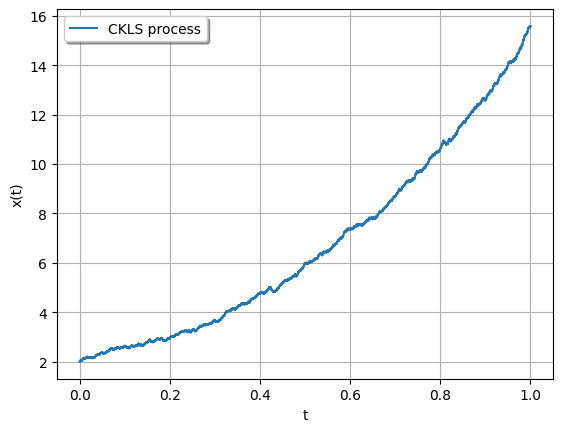

In [208]:
plt.plot(t_data, x_data_CKLS[:,0], label = 'CKLS process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [209]:
CKLSp.EulerEstimation(t_data, x_data_CKLS)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -33551.856626571716
        x: [ 1.111e+00  1.847e+00  4.870e-01  3.158e-01]
      nit: 19
      jac: [ 5.020e-02 -3.492e-02  3.201e-02  2.037e-02]
     nfev: 115
     njev: 23
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [210]:
#Confidence intervals
n = 50
result = np.zeros((n, 4))
for k in range(0, n):
    t_data, x_data_CKLS = CKLSp.EulerSolution()
    result[k] = CKLSp.EulerEstimation(t_data, x_data_CKLS).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 4):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = 1.1094391283804328 +- 0.18003944793344445 with 95.0% prob
theta1 = 1.9804904573766071 +- 0.04212119649678666 with 95.0% prob
theta2 = 0.5028948830959833 +- 0.0034500570865106505 with 95.0% prob
theta3 = 0.29765185960922147 +- 0.003611701916500819 with 95.0% prob


Task 4. Consider the Vasicek model
$$
dX_{t} = \theta_{1} (\theta_{2}- X_{t}) dt + \theta_{3} dW_{t},\qquad X_{0}=5
$$
with $\theta_{1}=3$, $\theta_{2}=2$ and $\theta_{3}=0.5$.

Use the Ozaki method and
*   generate the sample data $X_{t_i}$, time step $\Delta t =10^{-2}$,
*   estimate drift and diffusion coefficients,
*   compute confidence intervals for all parameters in a fitted SDE.

In [211]:
Nx = 1
Nt = 100

T = 1

params_OU = np.array([3, 2, 0.5])

x0 = 5
init_state = x0 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.EulerSolution()

In [212]:
# x_data_OU

In [213]:
OUp.OzakiEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -167.60590350738065
        x: [ 3.384e+00  1.752e+00  4.549e-01]
      nit: 14
      jac: [ 1.421e-05  7.958e-05 -2.274e-05]
     nfev: 96
     njev: 24
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [214]:
#Confidence intervals
n = 50
result = np.zeros((n, 3))
for k in range(0, n):
    t_data, x_data_OU = OUp.EulerSolution()
    result[k] = OUp.OzakiEstimation(t_data, x_data_OU).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 3):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = 3.106018054175568 +- 0.17034956073187357 with 95.0% prob
theta1 = 1.998721419647306 +- 0.0758506693369719 with 95.0% prob
theta2 = 0.3261272048646714 +- 0.11053532126510927 with 95.0% prob


Task 5. Consider the model
$$
  dX_{t} = a(t)X_{t} dt + \theta_{2}X_{t} dW_{t},\qquad X_{0}=10
$$
with $a(t) = \theta_{1}t$, $\theta_{1}=-2$, $\theta_{2}=0.2$.

Use the Shoji-Ozaki method and:
* generate the sample data $X_{t_i}$ time step $\Delta t =10^{-3}$,  
* estimate drift and diffusion coefficients,
* compute confidence intervals for all parameters in a fitted SDE.

In [215]:
Nx = 1
Nt = 1000

T = 1

params_T5 = np.array([-2, 0.2])

x0 = 5
init_state = x0 * np.ones(Nx)

T5p = Task5process(params_T5, T, Nx, Nt, init_state)

t_data, x_data_T5 = T5p.EulerSolution()

In [216]:
T5p.ShojiOzakiEstimation(t_data, x_data_T5)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -2343.883394636725
        x: [-1.747e+00  2.025e-01]
      nit: 15
      jac: [ 9.018e-02  1.945e-01]
     nfev: 96
     njev: 32
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

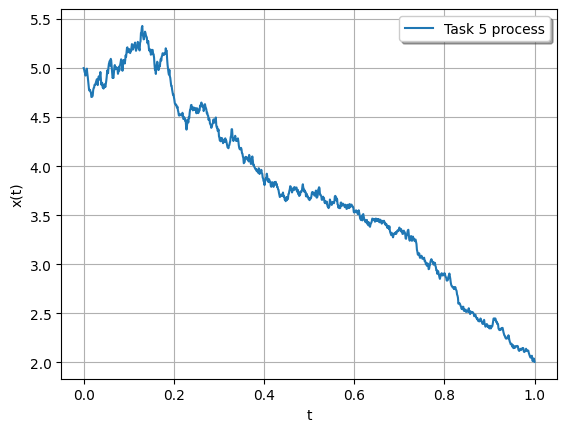

In [217]:
plt.plot(t_data, x_data_T5[:,0], label = 'Task 5 process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [218]:
#Confidence intervals
n = 50
result = np.zeros((n, 2))
for k in range(0, n):
    t_data, x_data_T5 = T5p.EulerSolution()
    result[k] = T5p.ShojiOzakiEstimation(t_data, x_data_T5).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 2):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = -2.026312352095691 +- 0.10234942198049594 with 95.0% prob
theta1 = 0.20050175253346608 +- 0.0015968611672528175 with 95.0% prob


### Task 6. Consider the Hull-White (extended Vasicek) model
$$
  dX_{t} = a(t)(b(t)-X_{t}) dt + \sigma(t) dW_{t},\qquad X_{0}=2
$$
with $a(t) = \theta_{1}t$, $b(t)=\theta_{2}\sqrt{t}$, the volatility depends on time $\sigma(t)=\theta_{3}t$.

Generate sample data of $X_t$ with time step $\Delta t =10^{-3}$ and $\theta_{1}=3$, $\theta_{2}=1$ and $\theta_{3}=0.3$, then
use the Kessler method and:
*   estimate drift and diffusion coefficients,
*   compute confidence intervals for all parameters in a fitted SDE.

In [219]:
Nx = 1
Nt = 100

T = 1

params_HW = np.array([3, 1, 0.3])

x0 = 2
init_state = x0 * np.ones(Nx)

HWp = HullWhiteprocess(params_HW, T, Nx, Nt, init_state)

t_data, x_data_HW = HWp.EulerSolution()

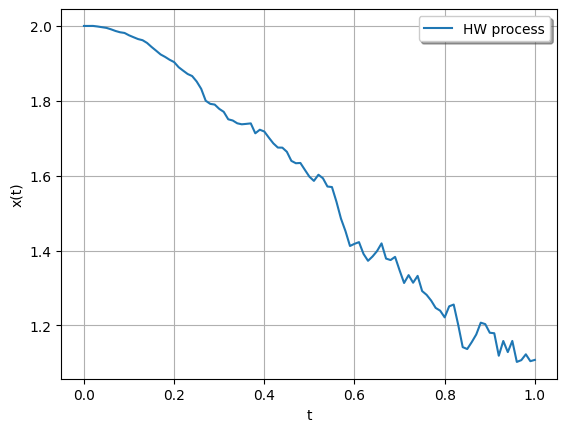

In [220]:
plt.plot(t_data, x_data_HW[:,0], label = 'HW process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [221]:
HWp.KesslerEstimation(t_data, x_data_HW)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -305.1674355915542
        x: [ 2.916e+00  9.843e-01  3.039e-01]
      nit: 32
      jac: [ 8.516e-02  5.074e-01  8.932e-02]
     nfev: 284
     njev: 71
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Task. Take a process from previous tasks and approximation method, find the solution, compute confidence intervals, and compare results with baseline.
Plot the graph and table.

Задания по вариантам
1. Байков Илья Павлович OU + Kessler
1. Гонгапшев Астемир Султанович CKLS + Shoji-Ozaki
1. Кудинкина Екатерина Андреевна CKLS + Kessler
1. Кулига Андрей Владимирович Vasicek + Euler
1. Мартыненко Александр Станиславович Vasicek + Shoji-Ozaki
1. Мироманов Даниил Борисович Vasicek + Kessler
1. Паршаков Никита Сергеевич extended Vasicek + Euler
1. Петренко Влада Витальевна extended Vasicek + Ozaki
1. Тумачев Серафим Дмитриевич extended Vasicek + Shoji-Ozaki
1. Хубиев Касымхан Юсуфович model 5 + Euler
1. Ширяева Софья Игоревна model 5 + Ozaki
1. Якунин Сергей Александрович model 5 + Kessler
1. Трофимов Яков Георгиевич CKLS + Ozaki


### Extended Vasicek + Ozaki

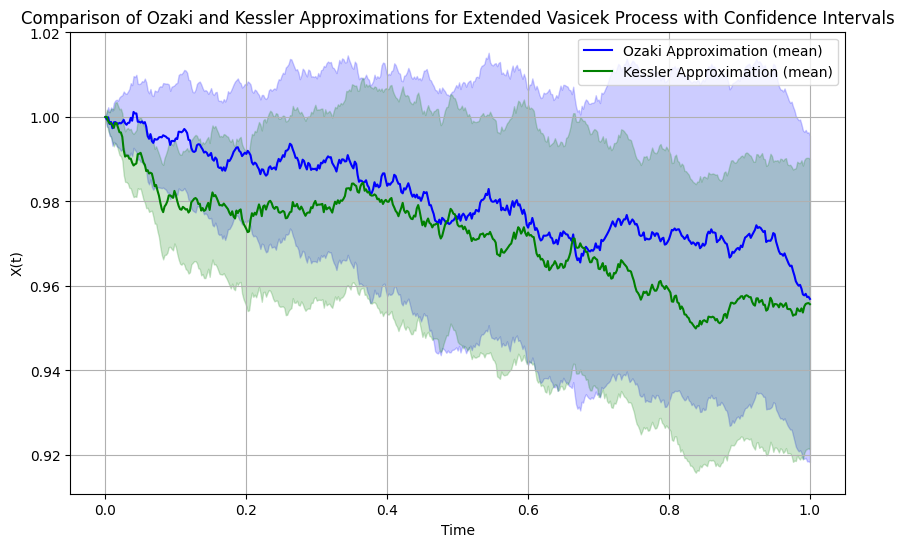

     Time     Ozaki  Kessler (baseline)  Difference (Ozaki - Kessler)
0     0.0  1.000000            1.000000                      0.000000
50    0.1  0.994923            0.981506                      0.013417
100   0.2  0.991263            0.973520                      0.017743
150   0.3  0.987378            0.979098                      0.008280
200   0.4  0.983716            0.979959                      0.003756
250   0.5  0.975839            0.974481                      0.001358
300   0.6  0.973805            0.972663                      0.001142
350   0.7  0.969380            0.964092                      0.005288
400   0.8  0.971079            0.959004                      0.012075
450   0.9  0.968569            0.957085                      0.011484
500   1.0  0.956935            0.955695                      0.001240
Ozaki Method:
  Mean: 0.9806237776135643
  95% Confidence Interval: (0.9528384222349252, 1.0084091329922036)

Kessler Method:
  Mean: 0.9712060957512418
  95% C

In [301]:
def vasicek_process(X0, alpha, mu, sigma, T, dt, method='ozaki'):
    """
    Generates a trajectory of the Vasicek process using either the Ozaki method or the Kessler method.
    """
    steps = int(T / dt)
    X = np.zeros(steps + 1)
    X[0] = X0
    
    for i in range(1, steps + 1):
        drift = alpha * (mu - X[i - 1]) * dt
        diffusion = sigma * np.sqrt(dt) * np.random.normal()
        
        if method == 'ozaki':
            X[i] = X[i - 1] + drift + diffusion
        elif method == 'kessler':
            # Kessler method with an additional term for better approximation
            X[i] = X[i - 1] + drift + diffusion + 0.5 * sigma**2 * dt
    
    return X


theta1, theta2, theta3 = 0.05, 0.1, 0.2 
X0 = 1       
T = 1    
dt = 1 / 500 
steps = int(T / dt)
np.random.seed(15)  

# Ozaki method
num_simulations = 100
simulations_ozaki = np.zeros((num_simulations, steps + 1))

for i in range(num_simulations):
    simulations_ozaki[i] = vasicek_process(X0, alpha, mu, sigma, T, dt, method='ozaki')

# Kessler method
simulations_kessler = np.zeros((num_simulations, steps + 1))

for i in range(num_simulations):
    simulations_kessler[i] = vasicek_process(X0, alpha, mu, sigma, T, dt, method='kessler')

# mean and std
mean_ozaki = np.mean(simulations_ozaki, axis=0)
std_dev_ozaki = np.std(simulations_ozaki, axis=0, ddof=1)

mean_kessler = np.mean(simulations_kessler, axis=0)
std_dev_kessler = np.std(simulations_kessler, axis=0, ddof=1)

# confidence interval
n = num_simulations 
q = t.ppf(1 - alpha / 2, n - 1)  

ci_ozaki_lower = mean_ozaki - q * std_dev_ozaki / np.sqrt(n)
ci_ozaki_upper = mean_ozaki + q * std_dev_ozaki / np.sqrt(n)

ci_kessler_lower = mean_kessler - q * std_dev_kessler / np.sqrt(n)
ci_kessler_upper = mean_kessler + q * std_dev_kessler / np.sqrt(n)

time_grid = np.linspace(0, T, steps + 1)
plt.figure(figsize=(10, 6))
plt.plot(time_grid, mean_ozaki, label="Ozaki Approximation (mean)", color="blue")
plt.fill_between(time_grid, ci_ozaki_lower, ci_ozaki_upper, color="blue", alpha=0.2)
plt.plot(time_grid, mean_kessler, label="Kessler Approximation (mean)", color="green")
plt.fill_between(time_grid, ci_kessler_lower, ci_kessler_upper, color="green", alpha=0.2)
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.legend()
plt.title("Comparison of Ozaki and Kessler Approximations for Extended Vasicek Process with Confidence Intervals")
plt.grid()
plt.show()

diff_ozaki_kessler = mean_ozaki - mean_kessler
df = pd.DataFrame({
    "Time": time_grid,
    "Ozaki": mean_ozaki,
    "Kessler (baseline)": mean_kessler,
    "Difference (Ozaki - Kessler)": diff_ozaki_kessler
})

step_index = int(0.1 / dt)  
df_step_0_1 = df.iloc[::step_index]

print(df_step_0_1)

for i, method in enumerate(["Ozaki", "Kessler"]):
    mean_method = mean_ozaki if i == 0 else mean_kessler
    ci_lower = ci_ozaki_lower if i == 0 else ci_kessler_lower
    ci_upper = ci_ozaki_upper if i == 0 else ci_kessler_upper
    print(f"{method} Method:")
    print(f"  Mean: {np.mean(mean_method)}")
    print(f"  95% Confidence Interval: ({np.mean(ci_lower)}, {np.mean(ci_upper)})")
    print()
